In [13]:
import pandas as pd
from pathlib import Path
import os
import sys
import pickle
import matplotlib.pyplot as plt
import networkx as nx

sys.path.append(str(Path().resolve().parent / "src"))

from ingest import load_cites_data
from mock import generate_mock_trafficking_data
from wtie.viz.map_routes import create_trade_routes_map
from wtie.graph.model import build_trade_graph, summarise_graph
from wtie.summary.tables import (
    top_species_by_quantity,
    top_trading_countries,
    top_trade_corridors,
)

**Load and Filter Data**

In [14]:
df_raw = pd.read_csv("../data/cites/sample.csv", low_memory=False)
df_legal = load_cites_data(df_raw)

df_legal.head()

,Id,Year,Appendix,Taxon,Class,Order,Family,Genus,Term,Quantity,...,Importer,Exporter,Origin,Purpose,Source,Reporter.type,Import.permit.RandomID,Export.permit.RandomID,Origin.permit.RandomID,synthetic
132,373288431,1987,II,Accipiter melanoleucus,Aves,Falconiformes,Accipitridae,Accipiter,live,1.0,...,US,GB,NaN,B,C,E,NaN,92bd46da37,NaN,False
135,719832341,1989,II,Accipiter melanoleucus,Aves,Falconiformes,Accipitridae,Accipiter,live,1.0,...,US,GB,NaN,B,C,E,NaN,6fe24641c6,NaN,False
276,464454951,1989,II,Accipiter nisus,Aves,Falconiformes,Accipitridae,Accipiter,live,1.0,...,CA,GB,NaN,T,C,I,NaN,ad7deade41,NaN,False
277,590332871,1989,II,Accipiter nisus,Aves,Falconiformes,Accipitridae,Accipiter,live,1.0,...,CA,GB,NaN,T,C,I,NaN,24391169af,NaN,False
278,898184781,1989,II,Accipiter nisus,Aves,Falconiformes,Accipitridae,Accipiter,live,1.0,...,CA,GB,NaN,T,C,I,NaN,8aa6830612,NaN,False


**Load Synthetic Mock Data**

In [15]:
df_synth = generate_mock_trafficking_data()
df_synth.head()

,Id,Year,Importer,Exporter,Purpose,Source,Quantity,Unit,Term,Genus,Family,Order,Class,Taxon,synthetic
0,SYNTH-0001,2019,RU,PK,Z,I,13,no.,LIV,Psittacus,Psittacidae,Psittaciformes,Aves,Psittacus erithacus,True
1,SYNTH-0002,2020,NG,BR,P,U,4,no.,LIV,Psittacus,Psittacidae,Psittaciformes,Aves,Psittacus erithacus,True
2,SYNTH-0003,2018,ID,KZ,Z,O,10,no.,LIV,Crocodylus,Crocodylidae,Crocodilia,Reptilia,Crocodylus niloticus,True
3,SYNTH-0004,2022,TH,LA,Z,U,15,no.,TRO,Falco,Falconidae,Falconiformes,Aves,Falco peregrinus,True
4,SYNTH-0005,2020,PA,TH,T,O,18,no.,SKI,Python,Pythonidae,Squamata,Reptilia,Python bivittatus,True


**Combine for Unified View**

In [16]:
df_all = pd.concat([df_legal, df_synth], ignore_index=True)
df_all["synthetic"].value_counts()

synthetic
False    706
True      50
Name: count, dtype: int64

**Top Importers/Exporters**

In [17]:
df_all["Exporter"].value_counts().head(10)

Exporter
DE    111
US    105
NL     90
GB     58
BE     52
TH     39
SG     35
ZA     24
MY     23
PH     22
Name: count, dtype: int64

In [18]:
df_all["Importer"].value_counts().head(10)

Importer
JP    176
US    107
DE     70
SG     46
GB     40
CA     29
CH     28
ZA     19
AT     18
ES     17
Name: count, dtype: int64

**Most Common Trade Routes**

In [19]:
df_all.groupby(["Exporter", "Importer", "synthetic"]).size().sort_values(
    ascending=False
).head(10)

Exporter  Importer  synthetic
NL        JP        False        57
TH        JP        False        35
GB        US        False        32
DE        JP        False        29
US        DE        False        26
MY        SG        False        22
US        JP        False        18
GD        SG        False        17
US        CA        False        14
CA        US        False        13
dtype: int64

**Most Common Species & Terms**

In [20]:
df_all["Taxon"].value_counts().head(10)

Taxon
Ambystoma mexicanum          101
Ara ararauna                  90
Aprosmictus erythropterus     82
Agapornis canus               36
Antaresia childreni           36
Aquila chrysaetos             27
Acrantophis dumerili          26
Anthropoides paradiseus       25
Antigone vipio                23
Alisterus amboinensis         19
Name: count, dtype: int64

In [21]:
df_all["Term"].value_counts()

Term
live         703
LIV           29
SKI           14
TRO            7
eggs           2
specimens      1
Name: count, dtype: int64

**Map**

In [22]:
os.makedirs("outputs", exist_ok=True)

# Point to the project root and the flat file path
storage_path = Path("../data/storage").resolve()
file_path = storage_path / "combined_trade_data"

with open(file_path, "rb") as f:
    df = pickle.load(f)

df.columns = df.columns.str.strip().str.lower()

output_path = Path("../data/outputs/trade_routes_map.html").resolve()

create_trade_routes_map(df, output_path=output_path)

Map saved to /Users/tom/Desktop/wildlife-trade-intelligence/data/outputs/trade_routes_map.html


/Users/tom/Desktop/wildlife-trade-intelligence/src/wtie/viz/map_routes.py:48: UserWarning: Missing coordinates for: ['SU', 'YU', 'DD', 'ZC', 'TW', 'HK']
  warnings.warn(f"Missing coordinates for: {missing}")


In [23]:
print(df.columns.tolist())

['id', 'year', 'appendix', 'taxon', 'class', 'order', 'family', 'genus', 'term', 'quantity', 'unit', 'importer', 'exporter', 'origin', 'purpose', 'source', 'reporter.type', 'import.permit.randomid', 'export.permit.randomid', 'origin.permit.randomid', 'synthetic']


In [24]:
exporters = df["exporter"].dropna().unique()
importers = df["importer"].dropna().unique()

all_countries = sorted(set(exporters) | set(importers))
print(f"🌍 Total countries in data: {len(all_countries)}")
print(all_countries)
print(df["synthetic"].value_counts())

🌍 Total countries in data: 80
['AE', 'AF', 'AR', 'AT', 'BB', 'BE', 'BH', 'BM', 'BR', 'BS', 'BY', 'CA', 'CG', 'CH', 'CL', 'CN', 'CW', 'CY', 'DD', 'DE', 'DK', 'DO', 'EC', 'EG', 'ES', 'FI', 'FR', 'GB', 'GD', 'GR', 'GY', 'HK', 'HU', 'ID', 'IL', 'IN', 'IR', 'IT', 'JM', 'JP', 'KH', 'KP', 'KR', 'KZ', 'LA', 'LK', 'MG', 'ML', 'MM', 'MT', 'MX', 'MY', 'NG', 'NL', 'NO', 'PA', 'PE', 'PH', 'PK', 'PT', 'RU', 'SA', 'SC', 'SD', 'SE', 'SG', 'SN', 'SU', 'SY', 'TH', 'TW', 'TZ', 'UA', 'US', 'VE', 'VN', 'YU', 'ZA', 'ZC', 'ZW']
synthetic
False    706
True      50
Name: count, dtype: int64


In [25]:
graph = build_trade_graph(df)
print(graph)

DiGraph with 80 nodes and 216 edges


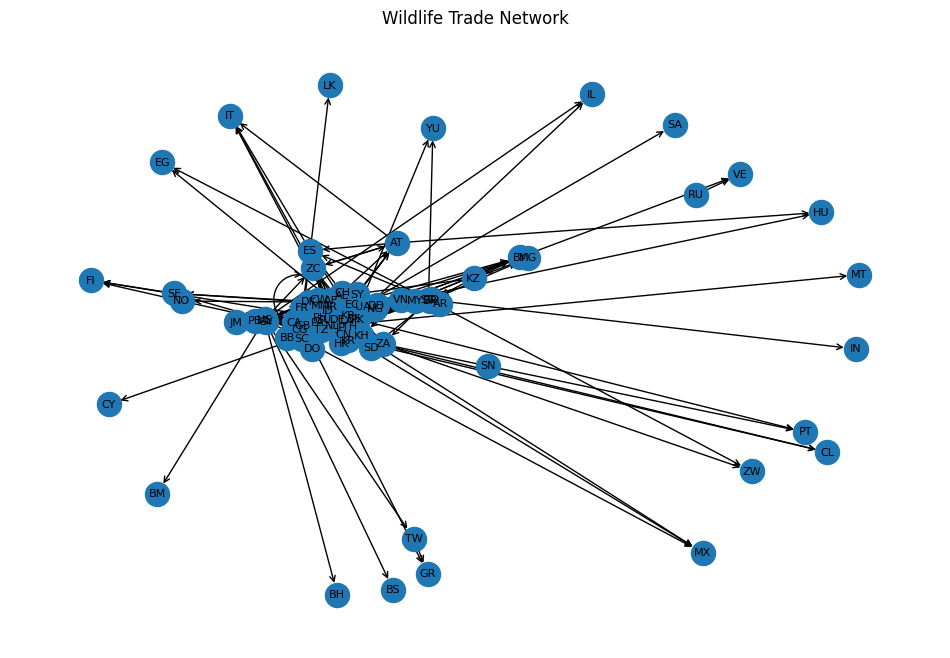

In [26]:
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(graph, seed=42)  # force-directed layout
nx.draw_networkx_nodes(graph, pos, node_size=300)
nx.draw_networkx_edges(graph, pos, arrowstyle="->", arrowsize=10)
nx.draw_networkx_labels(graph, pos, font_size=8)

plt.title("Wildlife Trade Network")
plt.axis("off")
plt.show()

In [27]:
summarise_graph(graph)

{'total_nodes': 80,
 'total_edges': 216,
 'top_out_degree': [('GB', 5195.0),
  ('DE', 4070.0),
  ('US', 4034.0),
  ('BE', 2182.0),
  ('SN', 1500.0)],
 'top_in_degree': [('JP', 8170.0),
  ('US', 6519.0),
  ('SE', 1624.0),
  ('NL', 1410.0),
  ('SG', 1189.0)],
 'synthetic_edge_count': 48,
 'legal_edge_count': 168}

In [28]:
top_species_by_quantity(df).style.format({"quantity": "{:.0f}"}).background_gradient(
    cmap="YlGnBu"
)

,genus,term,quantity
15,Ambystoma,live,13155
6,Agapornis,live,2747
12,Amandava,live,1900
5,Aerides,live,1325
30,Ara,live,843
9,Alisterus,live,591
25,Aprosmictus,live,575
14,Amazona,live,358
21,Antaresia,live,183
1,Acrantophis,live,128


In [29]:
top_trading_countries(df, role="exporter").style.format(
    {"quantity": "{:.0f}"}
).background_gradient(cmap="YlGnBu")

,exporter,quantity
20,GB,5195
14,DE,4070
56,US,4034
5,BE,2182
49,SN,1500
52,TH,1395
36,MY,709
38,NL,692
21,GD,443
34,ML,350


In [30]:
top_trading_countries(df, role="importer").style.format(
    {"quantity": "{:.0f}"}
).background_gradient(cmap="YlGnBu")

,importer,quantity
32,JP,8170
58,US,6519
52,SE,1624
44,NL,1410
53,SG,1189
49,PT,550
62,ZA,494
16,DE,493
10,CA,445
4,BE,253


In [31]:
top_trade_corridors(df).style.format({"quantity": "{:.0f}"}).background_gradient(
    cmap="YlGnBu"
)

,exporter,importer,quantity
61,DE,JP,3807
94,GB,US,2862
198,US,SE,1615
194,US,JP,1489
19,BE,US,1391
173,TH,JP,1375
92,GB,NL,1250
91,GB,JP,1032
166,SN,US,1000
121,MY,SG,699
